<a href="https://colab.research.google.com/github/Oh-HyunYoung/PytorchDL/blob/main/practices_2/ch09_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 9장 CNN을 활용한 이미지 인식

* "부록3 매트플롯립 입문"에서 한글 폰트를 올바르게 출력하기 위한 설치 방법을 설명했다. 설치 방법은 다음과 같다.

In [2]:
!sudo apt-get install -y fonts-nanum* | tail -n 1
!sudo fc-cache -fv
!rm -rf ~/.cache/matplotlib

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 4.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 31 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such 

In [3]:
# 필요 라이브러리 설치

!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

* 모든 설치가 끝나면 한글 폰트를 바르게 출력하기 위해 **[런타임]** -> **[런타임 다시시작]**을 클릭한 다음, 아래 셀부터 코드를 실행해 주십시오.

In [1]:
# 라이브러리 임포트

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# 폰트 관련 용도
import matplotlib.font_manager as fm

# 나눔 고딕 폰트의 경로 명시
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()

In [2]:
# 파이토치 관련 라이브러리

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [3]:
# warning 표시 끄기
import warnings
warnings.simplefilter('ignore')

# 기본 폰트 설정
plt.rcParams['font.family'] = font_name

# 기본 폰트 사이즈 변경
plt.rcParams['font.size'] = 14

# 기본 그래프 사이즈 변경
plt.rcParams['figure.figsize'] = (6,6)

# 기본 그리드 표시
# 필요에 따라 설정할 때는, plt.grid()
plt.rcParams['axes.grid'] = True

# 마이너스 기호 정상 출력
plt.rcParams['axes.unicode_minus'] = False

# 넘파이 부동소수점 자릿수 표시
np.set_printoptions(suppress=True, precision=4)

### GPU 확인하기

In [4]:
# 디바이스 할당

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 9.3 CNN의 처리 개요

In [5]:
data_root = './data'

# 샘플 손글씨 숫자 데이터 가져오기
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_set = datasets.MNIST(
    root = data_root,  train = True,  
    download = True, transform = transform)

image, label = train_set[0]
image = image.view(1,1,28,28)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
# 대각선상에만 가중치를 갖는 특수한 합성곱 함수를 만듦
conv1 = nn.Conv2d(1, 1, 3)

# bias를 0으로
nn.init.constant_(conv1.bias, 0.0)

# weight를 특수한 값으로
w1_np = np.array([[0,0,1],[0,1,0],[1,0,0]])
w1 = torch.tensor(w1_np).float()
w1 = w1.view(1,1,3,3)
conv1.weight.data = w1

In [7]:
# 손글씨 숫자에 3번 합성곱 처리를 함
image, label = train_set[0]
image = image.view(1,1,28,28)
w1 = conv1(image)
w2 = conv1(w1)
w3 = conv1(w2)
images = [image, w1, w2, w3]

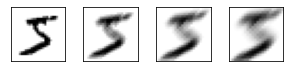

In [8]:
# 결과 화면 출력

plt.figure(figsize=(5, 1))
for i in range(4):
    size = 28 - i*2
    ax = plt.subplot(1, 4, i+1)
    img = images[i].data.numpy()
    plt.imshow(img.reshape(size, size),cmap='gray_r')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 9.4 파이토치에서 CNN을 구현하는 방법

### nn.Conv2d 와 nn.MaxPool2d

In [9]:
# CNN 모델 전반 부분, 레이어 함수 정의

conv1 = nn.Conv2d(3, 32, 3) # 입력 채널 수
relu = nn.ReLU(inplace=True) # 출력 채널 수
conv2 = nn.Conv2d(32, 32, 3) # 커널 사이즈
maxpool = nn.MaxPool2d((2,2)) 

In [10]:
# conv1 확인
print(conv1)

# conv1 내부 변수의 shape 확인
print(conv1.weight.shape) # 첫 요소인 '32'는 출력 채널 수 // 두 번째 요소 '3'은 입력 채널 수
print(conv1.bias.shape)

# conv2 내부 변수의 shape 확인
print(conv2.weight.shape) 
print(conv2.bias.shape)

Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([32, 32, 3, 3])
torch.Size([32])


In [11]:
# conv1의 weight[0]는 0번째 출력 채널의 가중치
w = conv1.weight[0]

# weight[0]의 shape과 값 확인
print(w.shape)
print(w.data.numpy())

torch.Size([3, 3, 3])
[[[-0.1865 -0.111   0.139 ]
  [ 0.0927  0.0273 -0.0286]
  [ 0.128  -0.1802  0.1116]]

 [[ 0.0447  0.1917  0.1171]
  [-0.1078  0.0962  0.1155]
  [ 0.042  -0.0164 -0.1309]]

 [[-0.0734 -0.086  -0.1454]
  [-0.1201 -0.0147 -0.0251]
  [-0.1172 -0.0979  0.1156]]]


In [12]:
# 더미로 입력과 같은 사이즈를 갖는 텐서를 생성
inputs = torch.randn(100, 3, 32, 32)
print(inputs.shape) #(학습 데이터 건수, 채널 수, 가로, 세로 화소 수)

torch.Size([100, 3, 32, 32])


In [13]:
# CNN 전반부 처리 시뮬레이션

x1 = conv1(inputs)
x2 = relu(x1)
x3 = conv2(x2)
x4 = relu(x3)
x5 = maxpool(x4)

In [14]:
# 각 변수의 shape 확인
# 가로 세로 화소 수가 2씩 줄어듬 
# -> 처리 과정을 거칠 때마다 '합성곱 처리 행렬의 사이즈 -1'만큼 출력 데이터의 화소 수가 줄어드는 것에 상응
print(inputs.shape)
print(x1.shape)
print(x2.shape)
print(x3.shape)
print(x4.shape)
print(x5.shape)

torch.Size([100, 3, 32, 32])
torch.Size([100, 32, 30, 30])
torch.Size([100, 32, 30, 30])
torch.Size([100, 32, 28, 28])
torch.Size([100, 32, 28, 28])
torch.Size([100, 32, 14, 14])


### nn.Sequential
- 함수가 직렬로 이어져 있는 형태
- 일일이 도중 단계를 변수로 적을 필요 없이 레이어 함수의 인스턴스명만 열거하면 된다.

In [15]:
# 함수 정의
features = nn.Sequential(
    conv1,
    relu,
    conv2,
    relu,
    maxpool
)

In [16]:
# 동작 테스트
outputs = features(inputs)

# 결과 확인
print(outputs.shape)

torch.Size([100, 32, 14, 14])


### nn.Flatten
- 합성곱 처리, 풀링 처리가 이뤄질 때 3계 텐서의 형태로 사용되던 데이터를 
- 선형 함수(nn.Linear)에서 사용할 수 있게끔 1계 텐서의 형태로 변환해 주는 것이다.

In [17]:
# 함수 정의
flatten = nn.Flatten()

# 동작 테스트
outputs2 = flatten(outputs)

# 결과 확인
print(outputs.shape)
print(outputs2.shape) # 32 * 14 * 14 = 6272

torch.Size([100, 32, 14, 14])
torch.Size([100, 6272])


## 9.5 공통 함수 사용하기

### eval_loss(손실 계산)

In [40]:
# 손실 계산용 - 계산 그래프 시각화에 사용할 수 있음
def eval_loss(loader, device, net, criterion):
  
    # 데이터로더에서 처음 한 개 세트를 가져옴
    for images, labels in loader:
        break

    # 디바이스 할당
    inputs = images.to(device)
    labels = labels.to(device)

    # 예측 계산
    outputs = net(inputs)

    # 손실 계산
    loss = criterion(outputs, labels)

    return loss

### fit(학습)
- net : 학습 대상의 모델 인스턴스
- optimizer : 최적화 함수의 인스턴스
- criterion : 손실 함수의 인스턴스
- num_epochs : 반복 횟수
- train_loader : 훈련용 데이터로더
- test_loader : 검증용 데이터로더
- device : GPU 또는 CPU
- history : 계산 도중의 history

In [18]:
# 학습용 함수
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):

    # tqdm 라이브러리 임포트
    from tqdm.notebook import tqdm

    base_epochs = len(history)
  
    for epoch in range(base_epochs, num_epochs+base_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        # 훈련 페이즈
        net.train()
        count = 0

        for inputs, labels in tqdm(train_loader):
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 경사 초기화
            optimizer.zero_grad()

            # 예측 계산
            outputs = net(inputs)

            # 손실 계산
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            # 경사 계산
            loss.backward()

            # 파라미터 수정
            optimizer.step()

            # 예측 라벨 산출
            predicted = torch.max(outputs, 1)[1]

            # 정답 건수 산출
            train_acc += (predicted == labels).sum().item()

            # 손실과 정확도 계산
            avg_train_loss = train_loss / count
            avg_train_acc = train_acc / count

        # 예측 페이즈
        net.eval()
        count = 0

        for inputs, labels in test_loader:
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 예측 계산
            outputs = net(inputs)

            # 손실 계산
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # 예측 라벨 산출
            predicted = torch.max(outputs, 1)[1]

            # 정답 건수 산출
            val_acc += (predicted == labels).sum().item()

            # 손실과 정확도 계산
            avg_val_loss = val_loss / count
            avg_val_acc = val_acc / count
    
        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
        item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
        history = np.vstack((history, item))
    return history

### eval_history(학습 로그)
- history 앞부분과 마지막 부분을 print 함수로 표시해서 학습 결과의 개요를 표시
- 학습 곡선을 손실, 정확도 두 가지로 출력

In [21]:
# 학습 로그 해석

def evaluate_history(history):
    # 손실과 정확도 확인
    print(f'초기상태 : 손실 : {history[0,3]:.5f}  정확도 : {history[0,4]:.5f}') 
    print(f'최종상태 : 손실 : {history[-1,3]:.5f}  정확도 : {history[-1,4]:.5f}' )

    num_epochs = len(history)
    unit = num_epochs / 10

    # 학습 곡선 출력(손실)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,1], 'b', label='훈련')
    plt.plot(history[:,0], history[:,3], 'k', label='검증')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('반복 횟수')
    plt.ylabel('손실')
    plt.title('학습 곡선(손실)')
    plt.legend()
    plt.show()

    # 학습 곡선 출력(정확도)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,2], 'b', label='훈련')
    plt.plot(history[:,0], history[:,4], 'k', label='검증')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('반복 횟수')
    plt.ylabel('정확도')
    plt.title('학습 곡선(정확도)')
    plt.legend()
    plt.show()

### show_images_labels(예측 결과 표시)
- loader : 검증용 데이터로더
- classes : 정답 데이터에 대응하는 라벨 값의 리스트, 이번 장의 실습을 예로 들면, CIFAR-10의 정답에 대응하는 라벨인 'plane', 'car', 'bird' 등을 포함한 리스트를 넘긴다.
- net : 사전에 학습이 끝난 모델의 인스턴스. None을 넘기면 정답 데이터만 표시되며, 학습 전에 데이터의 형태를 확인하고 싶을 때 사용
- device : 예측 계산에 사용하는 디바이스

In [23]:
# 이미지와 라벨 표시
def show_images_labels(loader, classes, net, device):

    # 데이터로더에서 처음 1세트를 가져오기
    for images, labels in loader:
        break
    # 표시 수는 50개
    n_size = min(len(images), 50)

    if net is not None:
      # 디바이스 할당
      inputs = images.to(device)
      labels = labels.to(device)

      # 예측 계산
      outputs = net(inputs)
      predicted = torch.max(outputs,1)[1]
      #images = images.to('cpu')

    # 처음 n_size개 표시
    plt.figure(figsize=(20, 15))
    for i in range(n_size):
        ax = plt.subplot(5, 10, i + 1)
        label_name = classes[labels[i]]
        # net이 None이 아닌 경우는 예측 결과도 타이틀에 표시함
        if net is not None:
          predicted_name = classes[predicted[i]]
          # 정답인지 아닌지 색으로 구분함
          if label_name == predicted_name:
            c = 'k'
          else:
            c = 'b'
          ax.set_title(label_name + ':' + predicted_name, c=c, fontsize=20)
        # net이 None인 경우는 정답 라벨만 표시
        else:
          ax.set_title(label_name, fontsize=20)
        # 텐서를 넘파이로 변환
        image_np = images[i].numpy().copy()
        # 축의 순서 변경 (channel, row, column) -> (row, column, channel)
        img = np.transpose(image_np, (1, 2, 0))
        # 값의 범위를[-1, 1] -> [0, 1]로 되돌림
        img = (img + 1)/2
        # 결과 표시
        plt.imshow(img)
        ax.set_axis_off()
    plt.show()


### torch_seed(난수 초기화)

In [24]:
# 파이토치 난수 고정

def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True


## 9.6 데이터 준비

In [27]:
# Transforms의 정의

# transformer1 1계 텐서화 // 전결합형 신경망에 사용

transform1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.Lambda(lambda x: x.view(-1)),
])

# transformer2 정규화만 실시 // CNN에 사용

# 검증 데이터용 : 정규화만 실시
transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])

In [28]:
# 데이터 취득용 함수 datasets

data_root = './data'

# 훈련 데이터셋 (1계 텐서 버전)
train_set1 = datasets.CIFAR10(
    root = data_root, train = True, 
    download = True, transform = transform1)

# 검증 데이터셋 (1계 텐서 버전)
test_set1 = datasets.CIFAR10(
    root = data_root, train = False, 
    download = True, transform = transform1)

# 훈련 데이터셋 (3계 텐서 버전)
train_set2 = datasets.CIFAR10(
    root =  data_root, train = True, 
    download = True, transform = transform2)

# 검증 데이터셋 (3계 텐서 버전)
test_set2 = datasets.CIFAR10(
    root = data_root, train = False, 
    download = True, transform = transform2)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### 데이터셋 확인

In [29]:
image1, label1 = train_set1[0]
image2, label2 = train_set2[0]

print(image1.shape)
print(image2.shape)

torch.Size([3072])
torch.Size([3, 32, 32])


In [30]:
# 데이터로더 정의

# 미니 배치 사이즈 지정
batch_size = 100

# 훈련용 데이터로더
# 훈련용이므로 셔플을 True로 설정
train_loader1 = DataLoader(train_set1, batch_size=batch_size, shuffle=True)

# 검증용 데이터로더
# 검증용이므로 셔플하지 않음
test_loader1 = DataLoader(test_set1,  batch_size=batch_size, shuffle=False) 

# 훈련용 데이터로더
# 훈련용이므로 셔플을 True로 설정
train_loader2 = DataLoader(train_set2, batch_size=batch_size, shuffle=True)

# 검증용 데이터로더
# 검증용이므로 셔플하지 않음
test_loader2 = DataLoader(test_set2,  batch_size=batch_size, shuffle=False) 


In [31]:
# train_loader1에서 한 세트 가져오기
for images1, labels1 in train_loader1:
    break

# train_loader2에서 한 세트 가져오기
for images2, labels2 in train_loader2:
    break

# それぞれのshape確認
print(images1.shape)
print(images2.shape)


torch.Size([100, 3072])
torch.Size([100, 3, 32, 32])


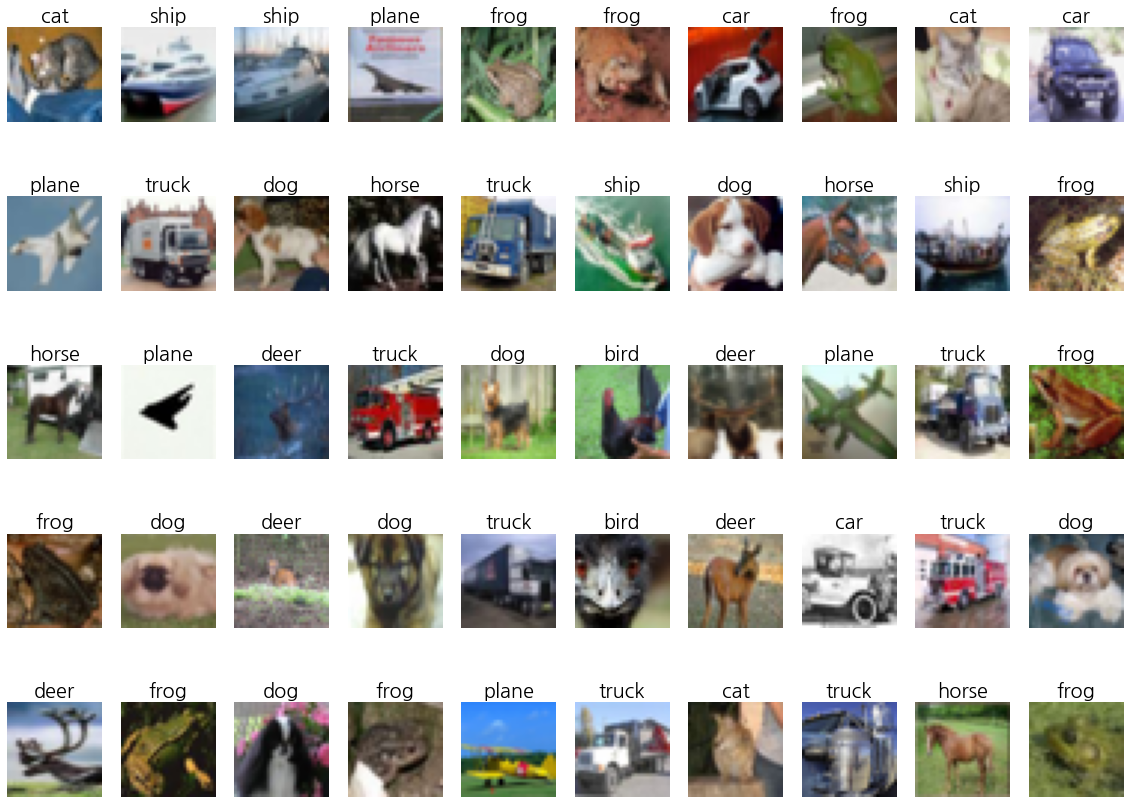

In [32]:
# 정답 라벨 정의
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 검증 데이터의 처음 50개를 출력
show_images_labels(test_loader2, classes, None, None)

## 9.7 모델 정의(전결합형)

### 학습용 파라미터 설정

In [33]:
# 입력 차원수는 3*32*32=3072
n_input = image1.view(-1).shape[0]

# 출력 차원수
# 분류 클래스의 수이므로　10
n_output = len(set(list(labels1.data.numpy())))

# 은닉층의 노드수
n_hidden = 128

# 결과 확인
print(f'n_input: {n_input}  n_hidden: {n_hidden} n_output: {n_output}')

n_input: 3072  n_hidden: 128 n_output: 10


In [34]:
# 모델 정의
# 3072입력 10출력 1은닉층을 포함한 신경망 모델

class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()

        # 은닉층 정의(은닉층의 노드수 : n_hidden)
        self.l1 = nn.Linear(n_input, n_hidden)

        # 출력층의 정의
        self.l2 = nn.Linear(n_hidden, n_output)

        # ReLU 함수 정의
        self.relu = nn.ReLU(inplace=True)
   
    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        return x3

### 모델 인스턴스 생성과 GPU 할당

In [35]:
# 모델 인스턴스 생성
net = Net(n_input, n_output, n_hidden).to(device)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 학습률
lr = 0.01

# 최적화 함수: 경사 하강법
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [36]:
# 모델 개요 표시 1

print(net)

Net(
  (l1): Linear(in_features=3072, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)


In [37]:
# 모델 개요 표시 2

summary(net, (100,3072),depth=1)

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [100, 10]                 --
├─Linear: 1-1                            [100, 128]                393,344
├─ReLU: 1-2                              [100, 128]                --
├─Linear: 1-3                            [100, 10]                 1,290
Total params: 394,634
Trainable params: 394,634
Non-trainable params: 0
Total mult-adds (M): 39.46
Input size (MB): 1.23
Forward/backward pass size (MB): 0.11
Params size (MB): 1.58
Estimated Total Size (MB): 2.92

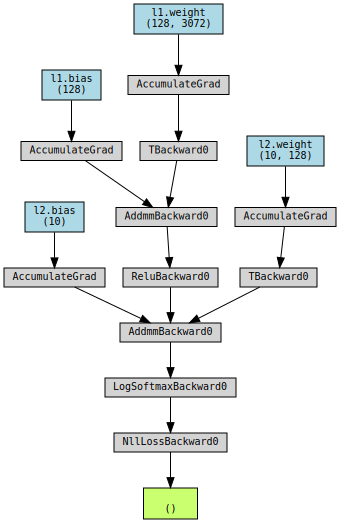

In [41]:
# 손실 계산
loss = eval_loss(test_loader1, device, net, criterion)

# 손실 계산 그래프 시각화
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

## 9.8 결과(전결합형)

### 학습

In [42]:
# 난수 초기화
torch_seed()

# 모델 인스턴스 생성
net = Net(n_input, n_output, n_hidden).to(device)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 학습률
lr = 0.01

# 최적화 함수: 경사 하강법
optimizer = optim.SGD(net.parameters(), lr=lr)

# 반복 횟수
num_epochs = 50

# 평가 결과 기록
history = np.zeros((0,5))

# 학습
history = fit(net, optimizer, criterion, num_epochs, train_loader1, test_loader1, device, history)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.01950 acc: 0.32202 val_loss: 0.01794, val_acc: 0.37690


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.01738 acc: 0.39568 val_loss: 0.01684, val_acc: 0.41740


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.01655 acc: 0.42412 val_loss: 0.01622, val_acc: 0.43760


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.01602 acc: 0.44230 val_loss: 0.01583, val_acc: 0.45060


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.01563 acc: 0.45544 val_loss: 0.01553, val_acc: 0.46170


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.01532 acc: 0.46814 val_loss: 0.01530, val_acc: 0.46810


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.01505 acc: 0.47696 val_loss: 0.01512, val_acc: 0.47440


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.01480 acc: 0.48628 val_loss: 0.01493, val_acc: 0.47790


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.01457 acc: 0.49592 val_loss: 0.01480, val_acc: 0.48650


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.01435 acc: 0.50398 val_loss: 0.01463, val_acc: 0.48910


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.01413 acc: 0.51106 val_loss: 0.01450, val_acc: 0.49680


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.01394 acc: 0.52020 val_loss: 0.01437, val_acc: 0.50230


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.01375 acc: 0.52662 val_loss: 0.01425, val_acc: 0.50590


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.01357 acc: 0.53482 val_loss: 0.01423, val_acc: 0.50530


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.01341 acc: 0.53934 val_loss: 0.01408, val_acc: 0.51240


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.01324 acc: 0.54576 val_loss: 0.01402, val_acc: 0.51130


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.01307 acc: 0.55166 val_loss: 0.01391, val_acc: 0.51500


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.01293 acc: 0.55666 val_loss: 0.01388, val_acc: 0.51470


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.01279 acc: 0.56156 val_loss: 0.01379, val_acc: 0.52050


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.01264 acc: 0.56668 val_loss: 0.01381, val_acc: 0.51680


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.01251 acc: 0.57088 val_loss: 0.01372, val_acc: 0.51780


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.01238 acc: 0.57696 val_loss: 0.01368, val_acc: 0.52510


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.01225 acc: 0.58040 val_loss: 0.01363, val_acc: 0.52490


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.01213 acc: 0.58438 val_loss: 0.01356, val_acc: 0.52610


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.01200 acc: 0.59100 val_loss: 0.01352, val_acc: 0.52820


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.01190 acc: 0.59368 val_loss: 0.01351, val_acc: 0.52790


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.01178 acc: 0.59852 val_loss: 0.01350, val_acc: 0.52520


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.01167 acc: 0.60162 val_loss: 0.01343, val_acc: 0.52900


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.01156 acc: 0.60546 val_loss: 0.01342, val_acc: 0.52800


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.01145 acc: 0.60900 val_loss: 0.01346, val_acc: 0.52990


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.01135 acc: 0.61458 val_loss: 0.01340, val_acc: 0.53000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.01124 acc: 0.61740 val_loss: 0.01338, val_acc: 0.52880


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.01115 acc: 0.62126 val_loss: 0.01339, val_acc: 0.53050


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.01105 acc: 0.62528 val_loss: 0.01342, val_acc: 0.52690


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.01096 acc: 0.62896 val_loss: 0.01341, val_acc: 0.52630


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.01086 acc: 0.63172 val_loss: 0.01334, val_acc: 0.53230


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.01077 acc: 0.63530 val_loss: 0.01340, val_acc: 0.52760


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.01068 acc: 0.63980 val_loss: 0.01336, val_acc: 0.53130


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.01059 acc: 0.64160 val_loss: 0.01342, val_acc: 0.53040


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.01051 acc: 0.64504 val_loss: 0.01349, val_acc: 0.52360


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.01041 acc: 0.64950 val_loss: 0.01341, val_acc: 0.52820


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.01033 acc: 0.65080 val_loss: 0.01347, val_acc: 0.52790


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.01025 acc: 0.65280 val_loss: 0.01347, val_acc: 0.52400


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.01016 acc: 0.65628 val_loss: 0.01346, val_acc: 0.52730


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.01007 acc: 0.65990 val_loss: 0.01345, val_acc: 0.52490


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.01000 acc: 0.66234 val_loss: 0.01345, val_acc: 0.52890


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.00993 acc: 0.66492 val_loss: 0.01349, val_acc: 0.52540


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.00984 acc: 0.66784 val_loss: 0.01352, val_acc: 0.52980


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.00977 acc: 0.67024 val_loss: 0.01364, val_acc: 0.51850


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.00970 acc: 0.67194 val_loss: 0.01354, val_acc: 0.53150


### 평가

초기상태 : 손실 : 0.01794  정확도 : 0.37690
최종상태 : 손실 : 0.01354  정확도 : 0.53150


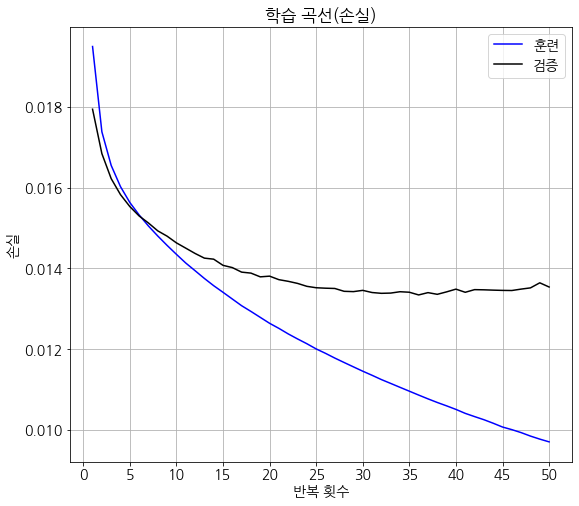

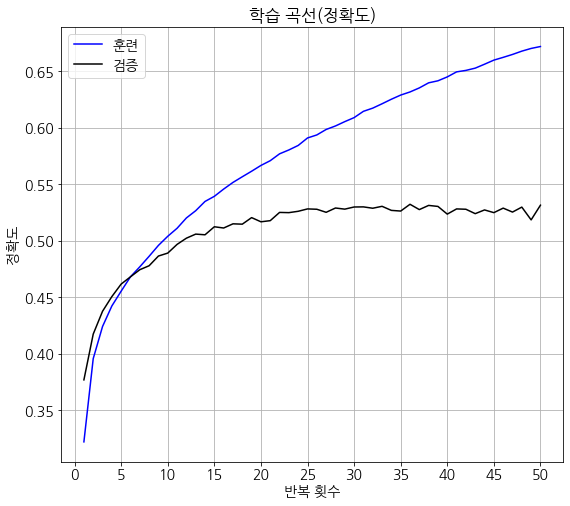

In [43]:
# 평가

evaluate_history(history)

## 9.9 모델 정의(CNN)

In [44]:
class CNN(nn.Module):
  def __init__(self, n_output, n_hidden):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 32, 3)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d((2,2))
    self.flatten = nn.Flatten()
    self.l1 = nn.Linear(6272, n_hidden)
    self.l2 = nn.Linear(n_hidden, n_output)

    self.features = nn.Sequential(
        self.conv1,
        self.relu,
        self.conv2,
        self.relu,
        self.maxpool)
    
    self.classifier = nn.Sequential(
       self.l1,
       self.relu,
       self.l2)

  def forward(self, x):
    x1 = self.features(x)
    x2 = self.flatten(x1)
    x3 = self.classifier(x2)
    return x3       

### 모델 인스턴스 생성

In [45]:
# 모델 인스턴스 생성
net = CNN(n_output, n_hidden).to(device)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 학습률
lr = 0.01

# 최적화 함수: 경사 하강법
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [46]:
# 모델 개요 표시 1

print(net)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=6272, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=6272, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [47]:
# 모델 개요 표시2

summary(net,(100,3,32,32),depth=1)

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [100, 10]                 --
├─Sequential: 1-1                        [100, 32, 14, 14]         10,144
├─Sequential: 1-4                        --                        (recursive)
├─Sequential: 1-5                        --                        (recursive)
├─Sequential: 1-4                        --                        (recursive)
├─Sequential: 1-5                        --                        (recursive)
├─Flatten: 1-6                           [100, 6272]               --
├─Sequential: 1-7                        [100, 10]                 804,234
Total params: 814,378
Trainable params: 814,378
Non-trainable params: 0
Total mult-adds (M): 886.11
Input size (MB): 1.23
Forward/backward pass size (MB): 43.22
Params size (MB): 3.26
Estimated Total Size (MB): 47.71

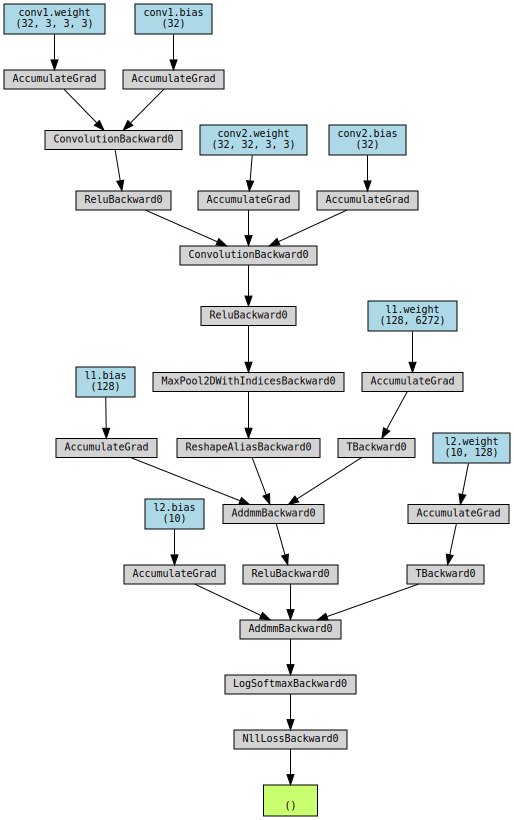

In [48]:
# 손실 계산
loss = eval_loss(test_loader2, device, net, criterion)

# 손실 계산 그래프 시각화
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

## 9.10 결과(CNN)

### 학습

In [49]:
# 난수 초기화
torch_seed()

# 모델 인스턴스 생성
net = CNN(n_output, n_hidden).to(device)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 학습률
lr = 0.01

# 최적화 함수: 경사 하강법
optimizer = optim.SGD(net.parameters(), lr=lr)

# 반복 횟수
num_epochs = 50

# 평가 결과 기록
history2 = np.zeros((0,5))

# 학습
history2 = fit(net, optimizer, criterion, num_epochs, train_loader2, test_loader2, device, history2)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.02082 acc: 0.26116 val_loss: 0.01866, val_acc: 0.34740


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.01781 acc: 0.37304 val_loss: 0.01677, val_acc: 0.40830


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.01613 acc: 0.43044 val_loss: 0.01530, val_acc: 0.46070


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.01485 acc: 0.47334 val_loss: 0.01449, val_acc: 0.48890


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.01408 acc: 0.49980 val_loss: 0.01370, val_acc: 0.51320


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.01350 acc: 0.52136 val_loss: 0.01333, val_acc: 0.52660


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.01304 acc: 0.53694 val_loss: 0.01293, val_acc: 0.53770


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.01253 acc: 0.55460 val_loss: 0.01255, val_acc: 0.55250


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.01205 acc: 0.57456 val_loss: 0.01237, val_acc: 0.56050


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.01158 acc: 0.59106 val_loss: 0.01185, val_acc: 0.58070


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.01116 acc: 0.60776 val_loss: 0.01166, val_acc: 0.58790


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.01077 acc: 0.62298 val_loss: 0.01172, val_acc: 0.58450


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.01036 acc: 0.63632 val_loss: 0.01112, val_acc: 0.60590


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.00997 acc: 0.64966 val_loss: 0.01091, val_acc: 0.61160


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.00959 acc: 0.66432 val_loss: 0.01112, val_acc: 0.60380


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.00922 acc: 0.67684 val_loss: 0.01054, val_acc: 0.63050


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.00882 acc: 0.69196 val_loss: 0.01061, val_acc: 0.62670


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.00846 acc: 0.70412 val_loss: 0.01011, val_acc: 0.64800


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.00808 acc: 0.71820 val_loss: 0.01019, val_acc: 0.64360


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.00773 acc: 0.73154 val_loss: 0.01051, val_acc: 0.63300


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.00738 acc: 0.74216 val_loss: 0.01001, val_acc: 0.65490


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.00701 acc: 0.75808 val_loss: 0.01019, val_acc: 0.65410


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.00674 acc: 0.76582 val_loss: 0.00995, val_acc: 0.65870


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.00637 acc: 0.78038 val_loss: 0.01006, val_acc: 0.66030


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.00604 acc: 0.79274 val_loss: 0.00999, val_acc: 0.66740


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.00568 acc: 0.80566 val_loss: 0.01044, val_acc: 0.64880


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.00541 acc: 0.81520 val_loss: 0.01056, val_acc: 0.66300


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.00508 acc: 0.82778 val_loss: 0.01110, val_acc: 0.64590


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.00473 acc: 0.83954 val_loss: 0.01061, val_acc: 0.66050


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.00442 acc: 0.85222 val_loss: 0.01091, val_acc: 0.66110


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.00409 acc: 0.86252 val_loss: 0.01104, val_acc: 0.66210


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.00381 acc: 0.87136 val_loss: 0.01139, val_acc: 0.65800


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.00353 acc: 0.88318 val_loss: 0.01119, val_acc: 0.66620


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.00325 acc: 0.89216 val_loss: 0.01215, val_acc: 0.65540


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.00295 acc: 0.90460 val_loss: 0.01262, val_acc: 0.65230


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.00271 acc: 0.91274 val_loss: 0.01276, val_acc: 0.65070


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.00241 acc: 0.92488 val_loss: 0.01267, val_acc: 0.66610


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.00217 acc: 0.93342 val_loss: 0.01307, val_acc: 0.66340


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.00192 acc: 0.94204 val_loss: 0.01382, val_acc: 0.65720


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.00175 acc: 0.95082 val_loss: 0.01441, val_acc: 0.65360


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.00149 acc: 0.95824 val_loss: 0.01538, val_acc: 0.65160


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.00130 acc: 0.96470 val_loss: 0.01594, val_acc: 0.64200


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.00106 acc: 0.97530 val_loss: 0.01540, val_acc: 0.65950


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.00094 acc: 0.97912 val_loss: 0.01599, val_acc: 0.65560


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.00089 acc: 0.98110 val_loss: 0.01630, val_acc: 0.66230


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.00065 acc: 0.98894 val_loss: 0.01703, val_acc: 0.65350


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.00047 acc: 0.99408 val_loss: 0.01720, val_acc: 0.66020


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.00036 acc: 0.99684 val_loss: 0.01773, val_acc: 0.66110


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.00029 acc: 0.99770 val_loss: 0.01844, val_acc: 0.66230


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.00025 acc: 0.99832 val_loss: 0.01863, val_acc: 0.66380


### 평가

초기상태 : 손실 : 0.01866  정확도 : 0.34740
최종상태 : 손실 : 0.01863  정확도 : 0.66380


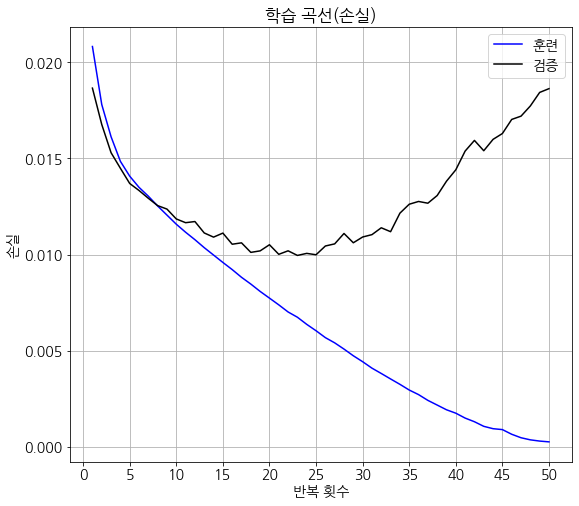

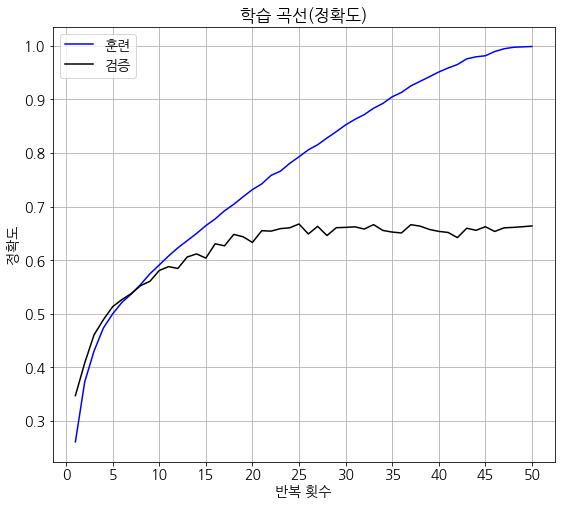

In [50]:
# 평가

evaluate_history(history2)

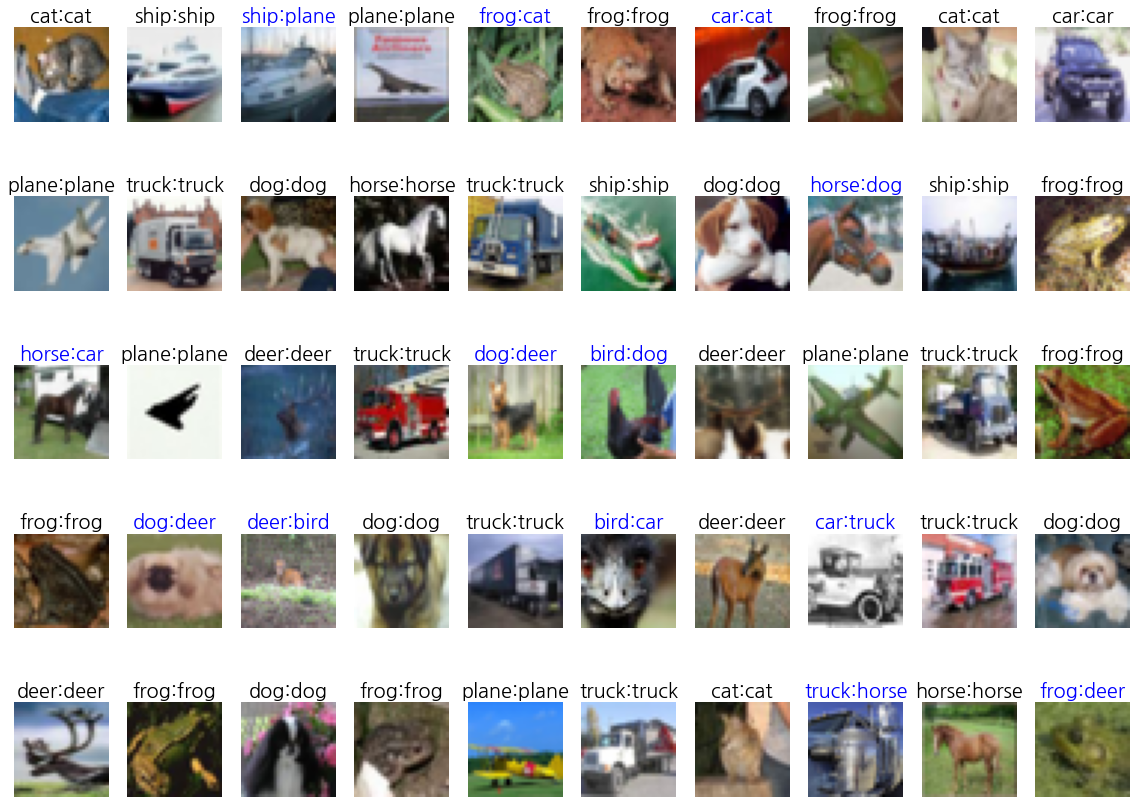

In [51]:
# 처음 50개 데이터 표시

show_images_labels(test_loader2, classes, net, device)

- 위의 CNN모델 과학습 일어남
- 반복횟수 20회에서 멈췄어야 했음
- 정확도 66%, 전결합형 모델은 53% -> 향상된 결과
- 이전 모델에 비해 높지만 실용적으로 사용하기엔 부족
- 다음 장에서 튜닝 방법에 대해 학습